# Overview

This is an analysis conducted for the Category Manager for Chips, who is seeking to better understand the types of customers who purchase Chips and their purchasing behaviour within the region.

In [1]:
#Import Modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import re
from datetime import date, timedelta
import scipy.stats as stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('bmh')
#sns.set_palette('ocean_r')

In [2]:
# Import Datasets

df_trans = pd.read_csv('datasets/QVI_transaction_data.csv')
df_cust = pd.read_csv('datasets/QVI_purchase_behaviour.csv')

### Transaction Data Exploration

In [3]:
# Explore first 10 rows
display(df_trans.head(10))

# Check shape
display(df_trans.shape)

# Check for nulls and datatypes
display(df_trans.info())

# Understand unique values in categorical columns
display(df_trans.nunique())

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,43604,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,43601,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,43601,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,43332,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,43330,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


(264836, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


None

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
dtype: int64

DATE column contains 364 unique values, ranging from 43282 to 43646. Format is CSV/Excel format, which begins on 1899-12-30.

STORE_NBR, LYLTY_CARD_NBR, TXN_ID, PROD_NBR datatype is integer, we'll convert these to Categories

###### Data Cleaning

In [4]:
## Replace values in DATE

# Convert to datetime - Begin 1899-12-30
df_trans['DATE'] = pd.to_datetime(df_trans['DATE'], unit='D', origin='1899-12-30')

## Date only has 364 unique values, so there is a date missing from this dataset

In [5]:
# Determine missing date value
transactions = df_trans.groupby('DATE').TXN_ID.count()
dates = transactions.index
date_set = set(dates[0] + timedelta(x) for x in range((dates[-1] - dates[0]).days))
missing = sorted(date_set - set(dates))
missing

[Timestamp('2018-12-25 00:00:00')]

There is no transactions on Christmas day, as that date is missing from the list of dates. We will explore this later on using a line plot.

In [6]:
## Convert STORE_NBR, LYLTY_CARD_NBR, TXN_ID, PROD_NBR to category dtype.
cols = ['STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR']

for col in cols:
    df_trans[col] = df_trans[col].astype('category')


In [7]:
#Describe the data
display(df_trans.describe(include='all', datetime_is_numeric=True).T)

#data info
display(df_trans.info())

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
DATE,264836,NaN,NaN,NaN,2018-12-30 00:52:12.879262208,2018-07-01 00:00:00,2018-09-30 00:00:00,2018-12-30 00:00:00,2019-03-31 00:00:00,2019-06-30 00:00:00,NaN
STORE_NBR,264836,272,226,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYLTY_CARD_NBR,264836,72637,172032,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TXN_ID,264836,263127,1162,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PROD_NBR,264836,114,102,3304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PROD_NAME,264836,114,Kettle Mozzarella Basil & Pesto 175g,3304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PROD_QTY,264836,NaN,NaN,NaN,1.90731,1,2,2,2,200,0.643654
TOT_SALES,264836,NaN,NaN,NaN,7.3042,1.5,5.4,7.4,9.2,650,3.08323


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  category      
 2   LYLTY_CARD_NBR  264836 non-null  category      
 3   TXN_ID          264836 non-null  category      
 4   PROD_NBR        264836 non-null  category      
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 25.9+ MB


None

---
- 272 unique stores included in the dataset, with store 226 having the most amount of transactions
    - Does this store have a higher proportion of customer type than others?
- 72,637 unique loyalty cards present in the dataset
- 263,127 transaction IDs
    - Need to understand what the duplicate IDs represent
- 114 different products
- Average sale is 1.9 units
    - Looks to be an outlier of 200, will need to explore this
- Average sale price is $7.3
---

The below code is to extract out the packet size and brand name, from the information in the PROD_NAME column.

In [8]:
## Parse out packet size

# Explore column
#display(set(df_trans.PROD_NAME.values))

# Reviewing the list, we can see that all values contain the chip size, and it's either a 2 digit or 3 digit number.

df_trans['packet_size'] = df_trans.PROD_NAME.str.extract(r'(\d+)', expand=True)

# Check

df_trans.packet_size.unique()

array(['175', '170', '150', '300', '330', '210', '270', '220', '125',
       '110', '134', '380', '180', '165', '135', '250', '200', '160',
       '190', '90', '70'], dtype=object)

Output of packet sizes seems reasonable - 70g to 380g

In [9]:
## Parse out brand

# Regex to get individual words
text = df_trans.PROD_NAME.to_string()
words_pattern = '[a-zA-Z]+'
word_list = re.findall(words_pattern, text, flags=re.IGNORECASE)

# Explore word counts
pd.value_counts(np.array(word_list))

g                  258772
Chips               49770
Kettle              41288
Smiths              28860
Salt                27976
Cheese              27890
Pringles            25102
Doritos             24962
Crinkle             23960
Corn                22063
Original            21560
Cut                 20754
Chip                18645
Chicken             18577
Salsa               18094
Cream               16926
Chilli              15390
Sea                 14145
Thins               14075
Sour                13882
Crisps              12607
Vinegar             12402
RRD                 11894
Sweet               11060
Infuzions           11057
Supreme             10963
Chives              10951
WW                  10320
Popd                 9693
Cobs                 9693
Tortilla             9580
Tostitos             9471
Twisties             9454
BBQ                  9434
Sensations           9429
Lime                 9347
Old                  9324
El                   9324
Paso        

There appears to be 'Salsa' and 'Dip' in this dataset. Spot checking the data, it seems like Dip is found for one chip packet, so we'll need to leave some instance of that in the set. Looks safe to remove any rows that have 'Salsa' in it, as it appears 'Dip' doesn't appear on it's own, rather it's found in conjunction with 'Salsa'

In [10]:
# Check length prior
display(len(df_trans))

# Word to remove
word_remove = ['Salsa']

# Filter dataframe
df_trans = df_trans[df_trans.PROD_NAME.str.contains('Salsa')==False]

# Check length after
display(len(df_trans))

## Difference is 18094, which matches the count in the output above for 'Salsa'

264836

246742

In [11]:
# Take first word of string as brand name

df_trans['brand_name'] = df_trans.PROD_NAME.str.split().str.get(0)

In [12]:
#df_trans.head(200)

In [13]:
## Need to clean up brand name, I.E Red & RRD is the same. WW is woolworths etc
df_trans.brand_name.value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: brand_name, dtype: int64

In [14]:
# Based on above list, I was able to combine certain names for brands. I.E. RRD & Red are for red rock deli.

# Create dictionary for these relationships

brand_map = {'Grain': 'Grain Waves',
             'GrnWves': 'Grain Waves',
             'Doritos': 'Doritos',
             'Dorito': 'Doritos',
             'Smiths': 'Smiths',
             'Smith': 'Smiths',
             'RRD': 'Red Rock Deli',
             'Red': 'Red Rock Deli',
             'WW': 'Woolworths',
             'Woolworths': 'Woolworths',
             'Natural': 'Natural Chip Company',
             'NCC': 'Natural Chip Company',
             'Snbts': 'Sunbites',
             'Sunbites': 'Sunbites',
             'Infuzions': 'Infuzions',
             'Infzns': 'Infuzions'}

# Map to brand_name column
df_trans['brand_name'] = df_trans.brand_name.replace(brand_map)

# Check 
df_trans.brand_name.value_counts()

Kettle                  41288
Smiths                  30353
Doritos                 25226
Pringles                25102
Red Rock Deli           16321
Infuzions               14201
Thins                   14075
Woolworths              11836
Cobs                     9693
Tostitos                 9471
Twisties                 9454
Grain Waves              7740
Natural Chip Company     7469
Tyrrells                 6442
Cheezels                 4603
CCs                      4551
Sunbites                 3008
Cheetos                  2927
Burger                   1564
French                   1418
Name: brand_name, dtype: int64

In [15]:
# Review dataframe to check cleaning results look reasonable
#df_trans.head(200)

---

##### Categorical Variables - Exploration

In [16]:
## Understand duplicate TXN_IDs

# Review rows of duplicated TXN_ID
mask = df_trans.TXN_ID.duplicated(keep=False)
display(df_trans[mask].head(20))

# Check to see largest number of duplicated values
display(set(df_trans.TXN_ID.value_counts().values))

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,packet_size,brand_name
41,2019-05-20,55,55073,48887,4,Dorito Corn Chp Supreme 380g,1,3.25,380,Doritos
42,2019-05-20,55,55073,48887,113,Twisties Chicken270g,1,4.60,270,Twisties
376,2019-01-10,7,7364,7739,50,Tostitos Lightly Salted 175g,2,8.80,175,Tostitos
377,2019-01-10,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.40,330,Doritos
418,2018-10-18,12,12301,10982,50,Tostitos Lightly Salted 175g,2,8.80,175,Tostitos
419,2018-10-18,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.80,150,Doritos
475,2018-09-08,16,16427,14546,99,Pringles Sthrn FriedChicken 134g,1,3.70,134,Pringles
476,2018-09-08,16,16427,14546,81,Pringles Original Crisps 134g,1,3.70,134,Pringles
510,2018-08-03,19,19272,16683,7,Smiths Crinkle Original 330g,2,11.40,330,Smiths
511,2018-08-03,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.60,110,Infuzions


{0, 1, 2, 3}

Seems as though if a customer purchases different chip packets, it's recorded under the same transaction ID, though on a different row. Based on this it appears that in this dataset a customer won't purchase more than 3 variations of chip packets in a single transaction.

---

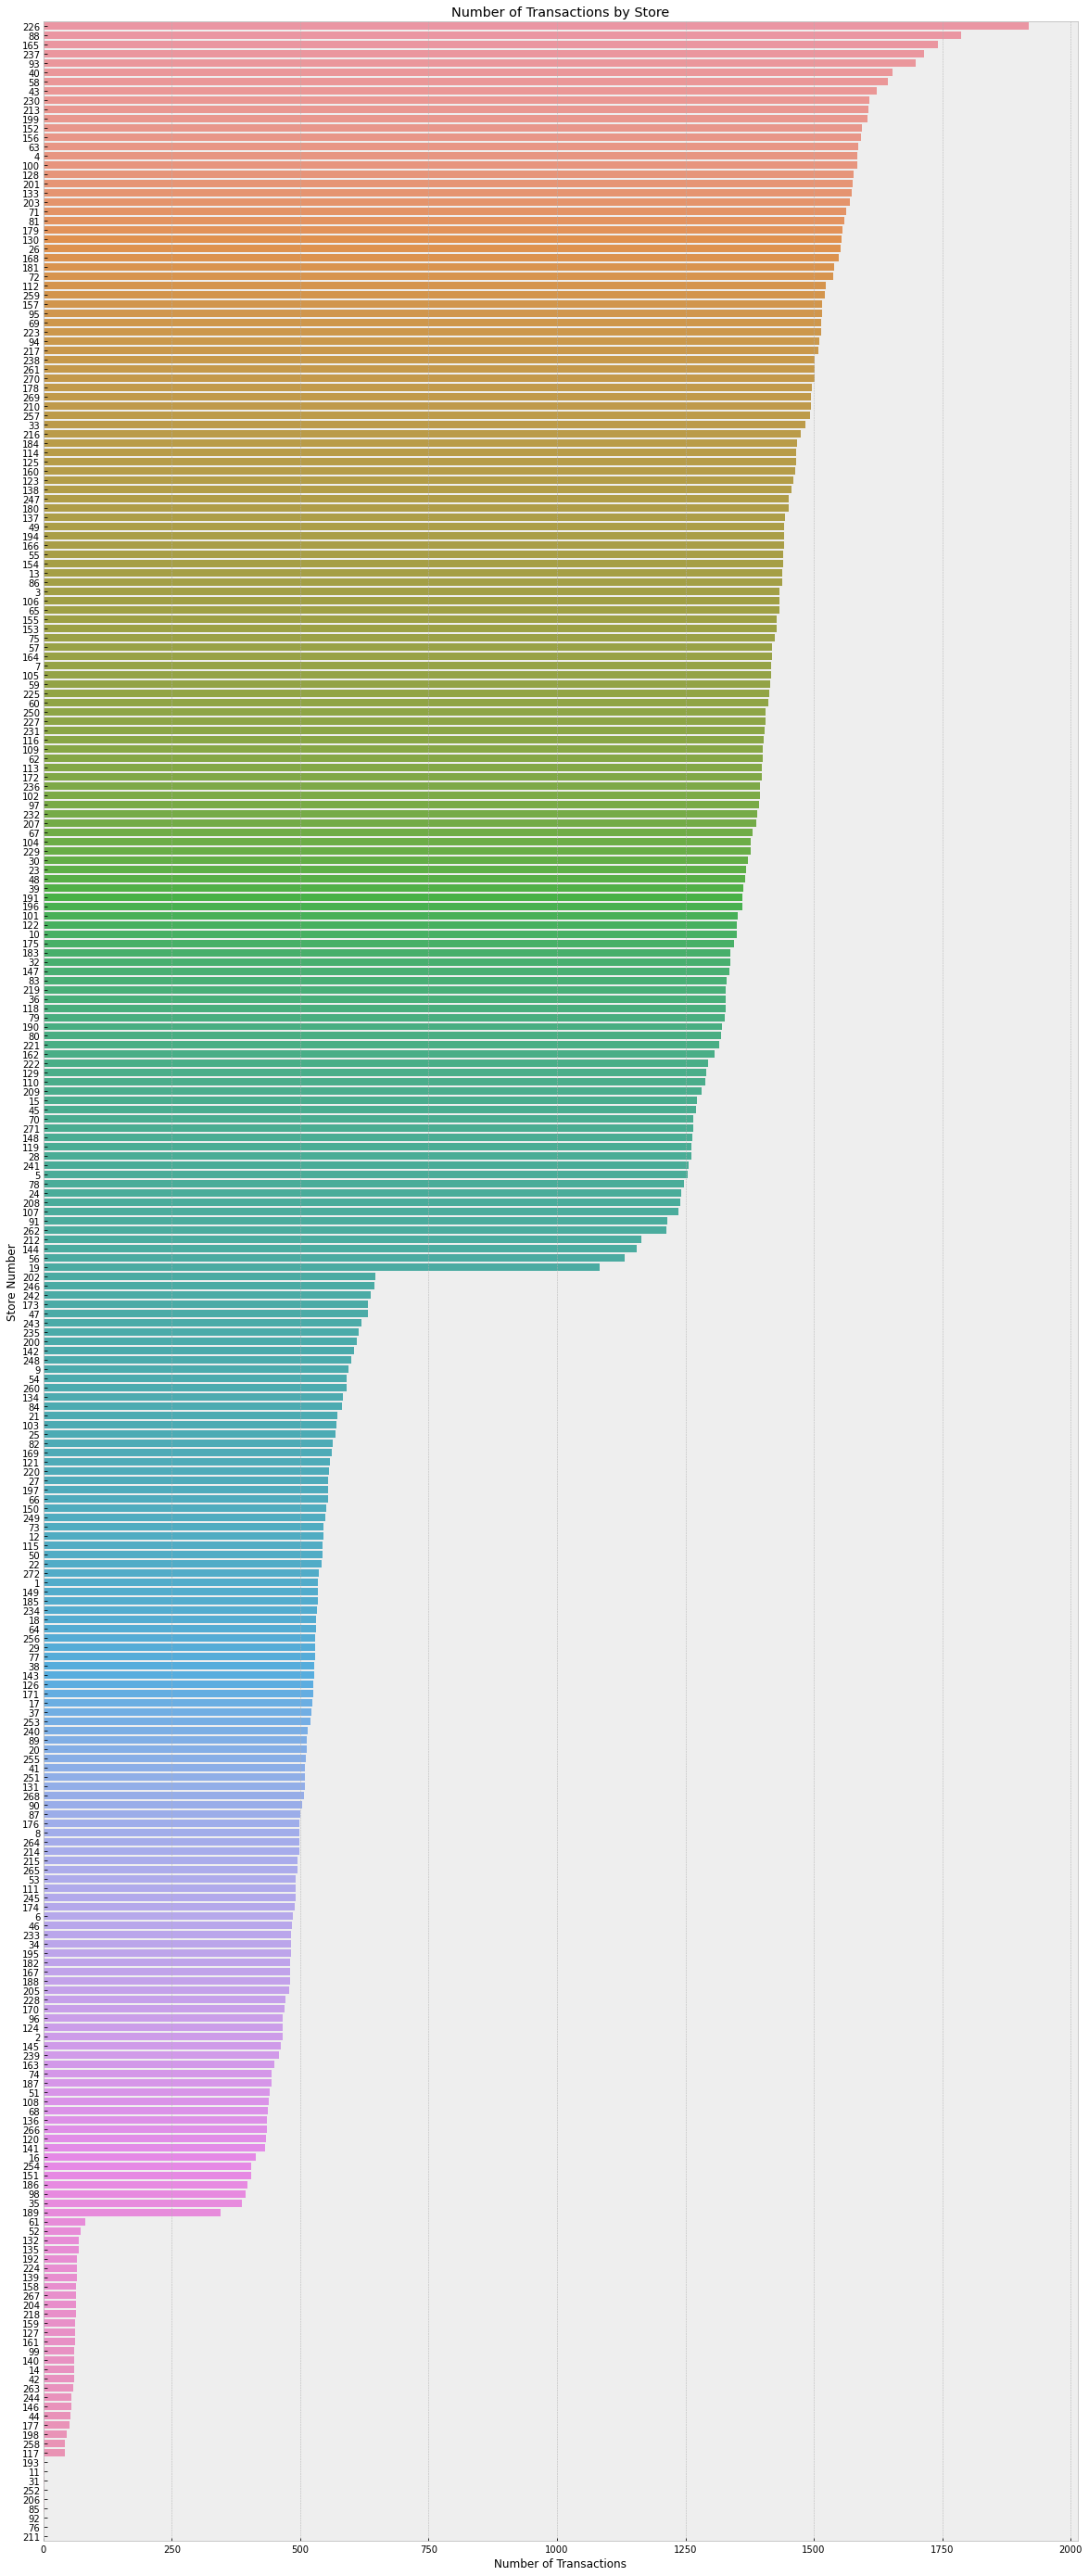

In [17]:
## STORE_NBR

# Groupby Stores
df_grouped = df_trans.groupby('STORE_NBR').agg({'TXN_ID': 'count'}).reset_index()

# Visualisation

fig, ax = plt.subplots(figsize=(20,50))

sns.barplot(data=df_grouped, y='STORE_NBR', x='TXN_ID', ax=ax,
           order=df_grouped.sort_values('TXN_ID', ascending=False).STORE_NBR)

ax.set_title('Number of Transactions by Store')
ax.set_ylabel('Store Number')
ax.set_xlabel('Number of Transactions')

plt.show()

We can roughly group the stores into 3-4 categories, which can be characterised by the steep drop offs. This may be indicative of the size or location of each of the stores. 

---

In [18]:
# Loyalty Card Number

df_trans.LYLTY_CARD_NBR.nunique()

71288

This dataset contains purchasing information of 71287 customers

---

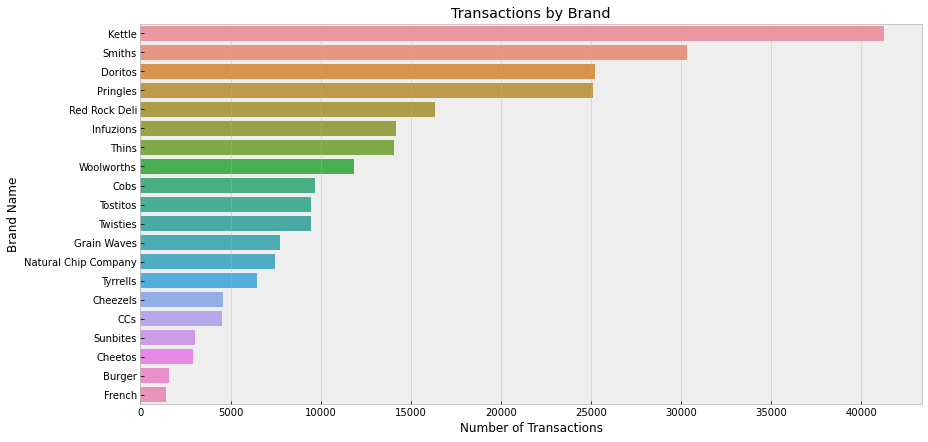

In [19]:
# Brand Name by transactions

# Draw plot
fig, ax = plt.subplots(figsize=(14,7))

# Create countplot
sns.countplot(data=df_trans, y='brand_name', order=df_trans['brand_name'].value_counts().index)

# Formatting
ax.set_title('Transactions by Brand')
ax.set_ylabel('Brand Name')
ax.set_xlabel('Number of Transactions')

plt.show()

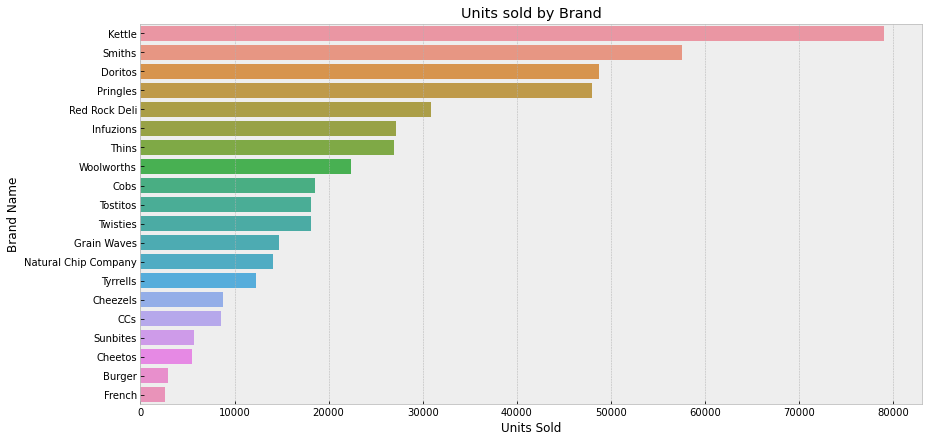

,PROD_QTY
brand_name,
Kettle,16.79
Smiths,12.23
Doritos,10.35
Pringles,10.20
Red Rock Deli,6.56
Infuzions,5.76
Thins,5.72
Woolworths,4.74
Cobs,3.94


In [20]:
# Brand Name by units sold

# Group by brand name, and units sold

df_grouped = df_trans.groupby('brand_name').agg({'PROD_QTY': 'sum'}).sort_values(by='PROD_QTY', ascending=False)

# Draw plot
fig, ax = plt.subplots(figsize=(14,7))

# Create barplot
sns.barplot(data=df_grouped, y=df_grouped.index, x='PROD_QTY', ax=ax)

# Formatting
ax.set_title('Units sold by Brand')
ax.set_ylabel('Brand Name')
ax.set_xlabel('Units Sold')

plt.show()

# Show % 
display(df_grouped.apply(lambda x: np.round((x/x.sum()*100),2), axis=0))

Kettle, Smiths, Doritos, Pringles account for 49.53% of total units sold.

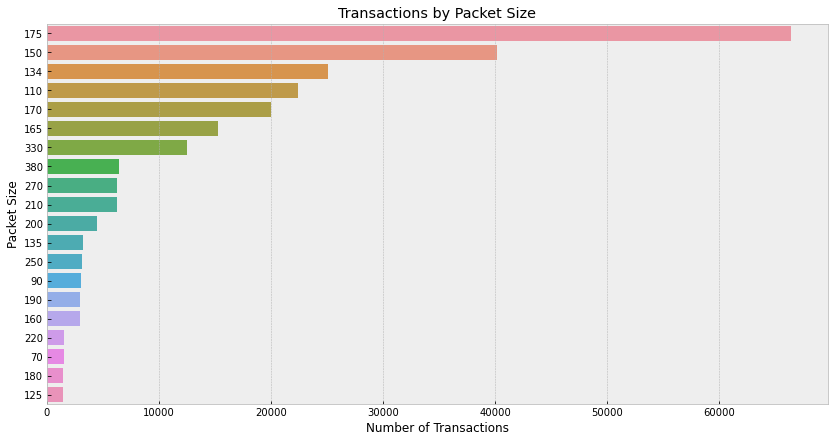

In [21]:
# Packet size by transactions

# Draw plot
fig, ax = plt.subplots(figsize=(14,7))

# Create countplot
sns.countplot(data=df_trans, y='packet_size', order=df_trans['packet_size'].value_counts().index)

# Formatting
ax.set_title('Transactions by Packet Size')
ax.set_ylabel('Packet Size')
ax.set_xlabel('Number of Transactions')

plt.show()

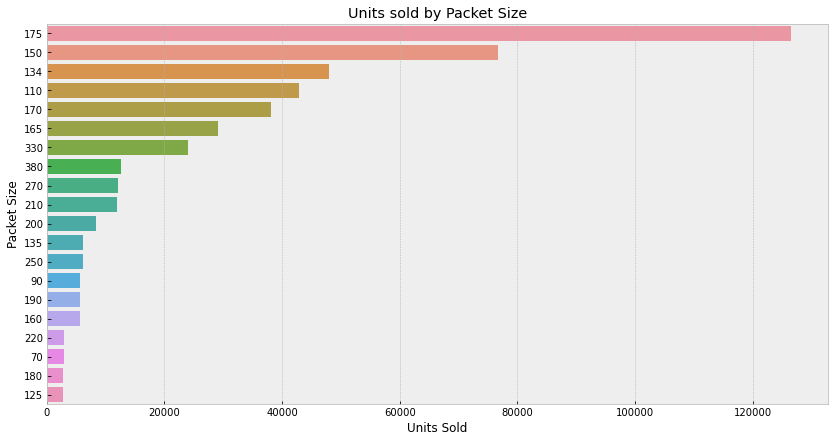

,PROD_QTY
packet_size,
175,26.86
150,16.28
134,10.20
110,9.10
170,8.09
165,6.17
330,5.10
380,2.69
270,2.56


In [22]:
# Packet Size by units sold

# Group by brand name, and units sold

df_grouped = df_trans.groupby('packet_size').agg({'PROD_QTY': 'sum'}).sort_values(by='PROD_QTY', ascending=False)

# Draw plot
fig, ax = plt.subplots(figsize=(14,7))

# Create barplot
sns.barplot(data=df_grouped, y=df_grouped.index, x='PROD_QTY', ax=ax)

# Formatting
ax.set_title('Units sold by Packet Size')
ax.set_ylabel('Packet Size')
ax.set_xlabel('Units Sold')

plt.show()

# Show % 
display(df_grouped.apply(lambda x: np.round((x/x.sum()*100),2), axis=0))

175, 150, 134 and 110 gram packets account for more than 50% of the units sold

##### Numerical Variables - Exploration

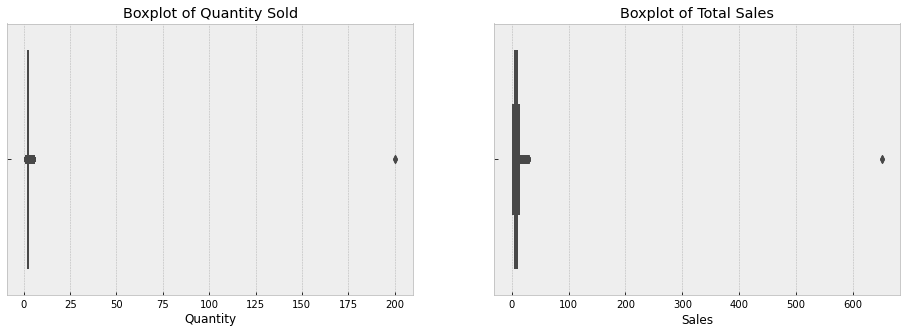

In [23]:
# Numerical Variables - Visualisations

fig, ax = plt.subplots(1,2,figsize=(16,5))

# PROD_QTY
sns.boxplot(data=df_trans, x='PROD_QTY', ax=ax[0])
ax[0].set_title('Boxplot of Quantity Sold')
ax[0].set_xlabel('Quantity')

# TOT_SALES
sns.boxplot(data=df_trans, x='TOT_SALES', ax=ax[1])
ax[1].set_title('Boxplot of Total Sales')
ax[1].set_xlabel('Sales')

plt.show()

There is clearly an outlier from the visuals above, we'll first investigate these rows, and make a decision on what to do from there.

In [24]:
# Check rows with outliers
display(df_trans[df_trans.PROD_QTY > 50])

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,packet_size,brand_name
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380,Doritos
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380,Doritos


This looks to be for the same customer on two different occasions. We can assume this unusual purchase may have been for commerical purposes, and can be removed for the purpose of this analysis, as we're concerned on retail customers.

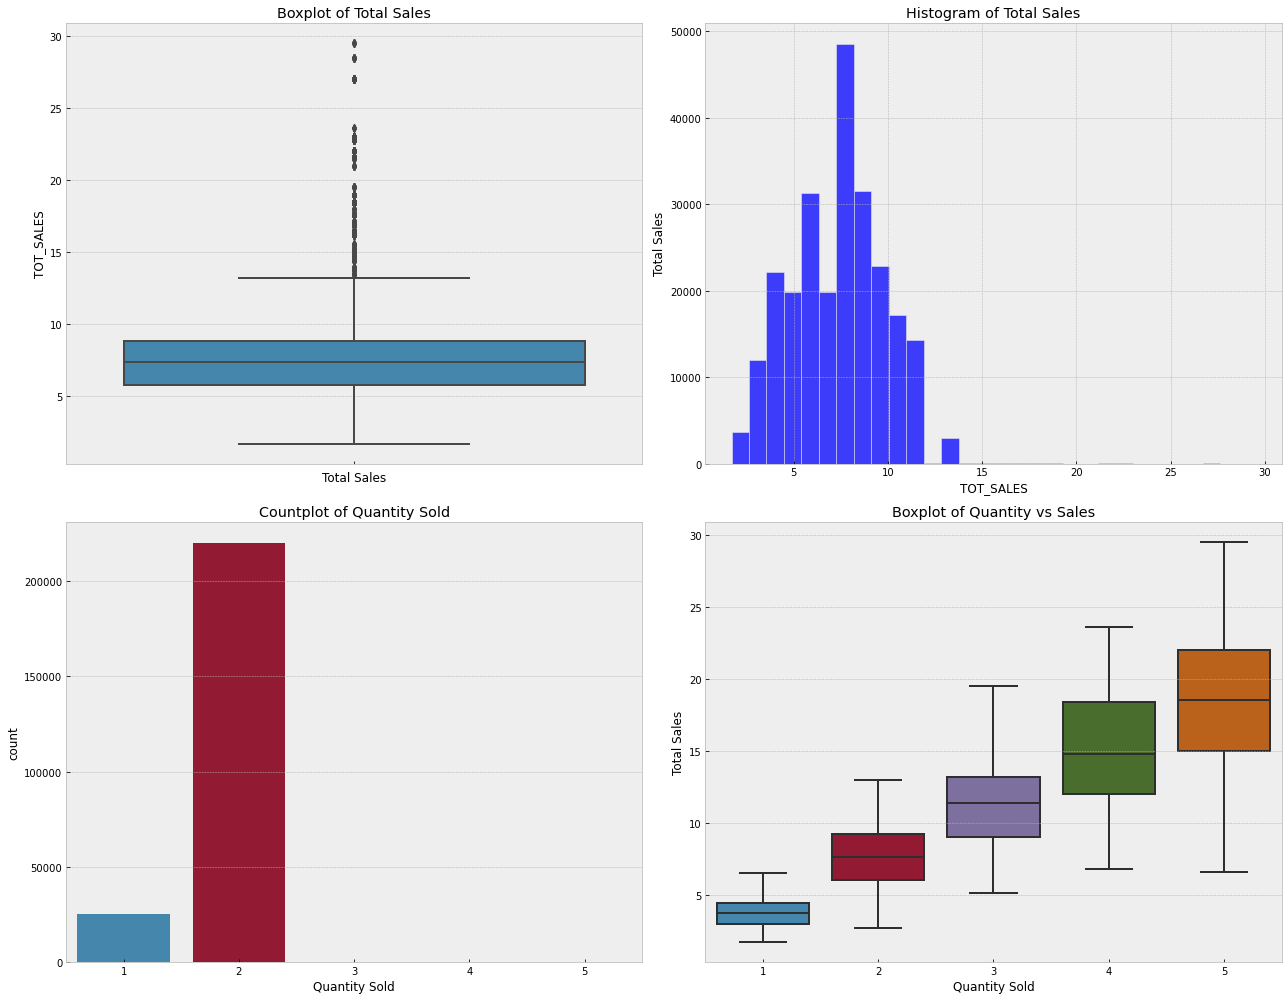

In [25]:
# Filter out outliers
df_trans = df_trans[df_trans.PROD_QTY < 50]

# Re-run visuals
fig, ax = plt.subplots(2,2,figsize=(18,14))

# TOT_SALES
sns.boxplot(data=df_trans, y='TOT_SALES', ax=ax[0,0])
ax[0,0].set_title('Boxplot of Total Sales')
ax[0,0].set_xlabel('Total Sales')

sns.histplot(data=df_trans, x='TOT_SALES', ax=ax[0,1], bins=30)
ax[0,1].set_title('Histogram of Total Sales')
ax[0,1].set_ylabel('Total Sales')

# PROD_QTY
sns.countplot(data=df_trans, x='PROD_QTY', ax=ax[1,0])
ax[1,0].set_title('Countplot of Quantity Sold')
ax[1,0].set_xlabel('Quantity Sold')

# PROD_QTY vs TOT_SALES
sns.boxplot(data=df_trans, x='PROD_QTY', y='TOT_SALES', ax=ax[1,1])
ax[1,1].set_title('Boxplot of Quantity vs Sales')
ax[1,1].set_xlabel('Quantity Sold')
ax[1,1].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()

- Half of the transactions had total sales between $5.4 and \\$9.2. 
- Most customers would purchase 2 chip packets per transaction
- We see higher variance in total sales, as the quantity of chips sold increases

---

In [26]:
# Summary Statistics of Transactions

transactions.describe()

count    364.000000
mean     727.571429
std       35.256836
min      648.000000
25%      706.750000
50%      724.000000
75%      744.250000
max      939.000000
Name: TXN_ID, dtype: float64

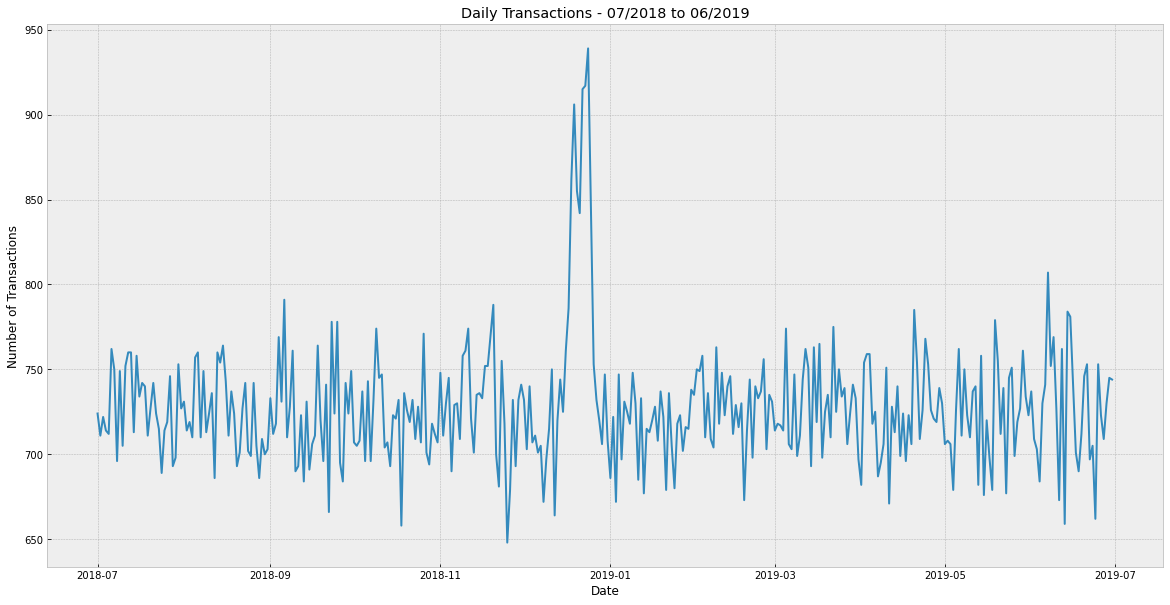

In [27]:
# Time series of Daily Transactions

# Draw plot
fig, ax = plt.subplots(figsize=(20,10))

# Plot line
sns.lineplot(data=transactions)

#Formatting
ax.set_title('Daily Transactions - 07/2018 to 06/2019')
ax.set_ylabel('Number of Transactions')
ax.set_xlabel('Date')

plt.show()

Daily transactions hover around 727 per day, with a ramp up and spike around Christmas time. Transactions are closer to 900 around this time.

Transactions appear to bounce between 650 and 800 throughout the year.

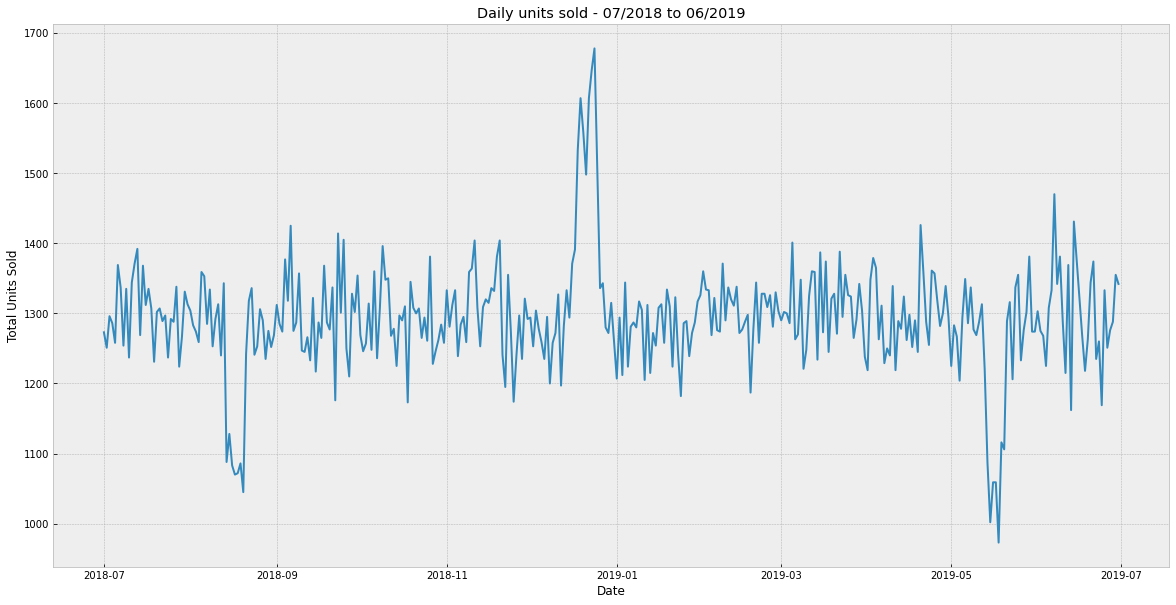

In [28]:
# Time series of Daily units sold

# Group by date and sum of total units sold
df_grouped = df_trans.groupby('DATE').agg({'PROD_QTY': 'sum'})

# Draw figure and axes
fig, ax = plt.subplots(figsize=(20,10))

#Plot line
sns.lineplot(x=df_grouped.index, y='PROD_QTY', data=df_grouped, ax=ax)

#Formatting
ax.set_title('Daily units sold - 07/2018 to 06/2019')
ax.set_ylabel('Total Units Sold')
ax.set_xlabel('Date')

plt.show()

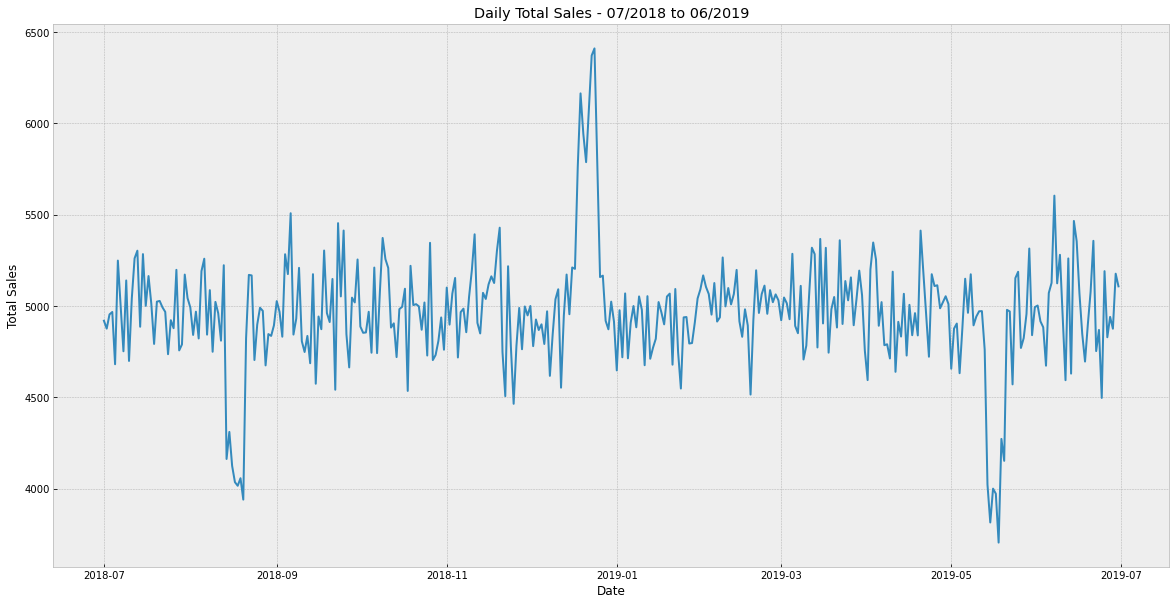

In [29]:
# Time series of daily total sales

# Group by date and sum of total sales
df_grouped = df_trans.groupby('DATE').agg({'TOT_SALES': 'sum'})

# Draw figure and axes
fig, ax = plt.subplots(figsize=(20,10))

#Plot line
sns.lineplot(x=df_grouped.index, y='TOT_SALES', data=df_grouped, ax=ax)

#Formatting
ax.set_title('Daily Total Sales - 07/2018 to 06/2019')
ax.set_ylabel('Total Sales')
ax.set_xlabel('Date')

plt.show()

Taking into account sales, and units sold the pattern of these graphs are very similar to the number of transactions graph. The only difference is a sharp brief decline around August 2018 and May 2019.

This may be an interesting area to explore, as to why this decline occured?

We'll also quickly view the transactions graph, using a 7 day rolling average, to smooth out the fluctuations.

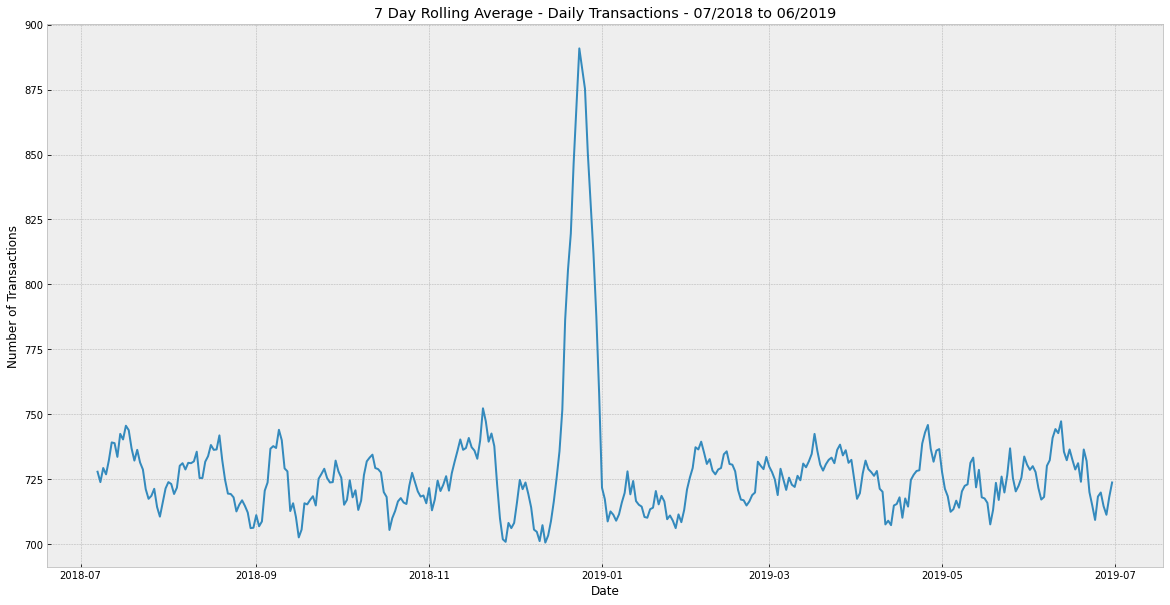

In [30]:
# Time series of 7-day Rolling Avergae - Daily Transactions

# Draw plot
fig, ax = plt.subplots(figsize=(20,10))

# Plot line
sns.lineplot(data=transactions.rolling(7).mean())

#Formatting
ax.set_title('7 Day Rolling Average - Daily Transactions - 07/2018 to 06/2019')
ax.set_ylabel('Number of Transactions')
ax.set_xlabel('Date')

plt.show()

This reinforces that the primary spike for chip sales, from a seasonality point of view, is Christmas.

#### Customer Data Exploration

In [31]:
# Explore first 10 rows
display(df_cust.head(10))

# Info
display(df_cust.info())

# Number of values in each variable
display(df_cust.LYLTY_CARD_NBR.nunique())
display(df_cust.LIFESTAGE.nunique())
display(df_cust.PREMIUM_CUSTOMER.nunique())

## 7 Values in LIFESTAGE and 3 in PREIMUM_CUSTOMER - Will be OK to plot bar graphs of each. No duplicates in LYLTY_CARD_NBR.

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
5,1007,YOUNG SINGLES/COUPLES,Budget
6,1009,NEW FAMILIES,Premium
7,1010,YOUNG SINGLES/COUPLES,Mainstream
8,1011,OLDER SINGLES/COUPLES,Mainstream
9,1012,OLDER FAMILIES,Mainstream


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


None

72637

7

3

Note that there are 72637 unique values in Loyalty card numbers, which matches the amount in the transactions dataset.

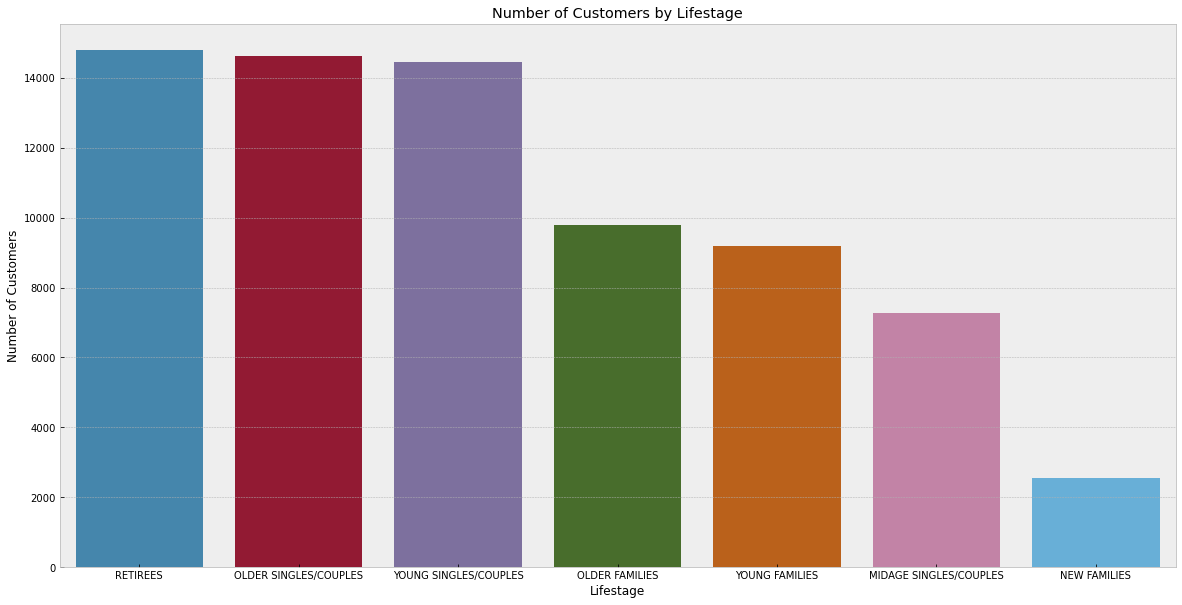

<Figure size 432x288 with 0 Axes>

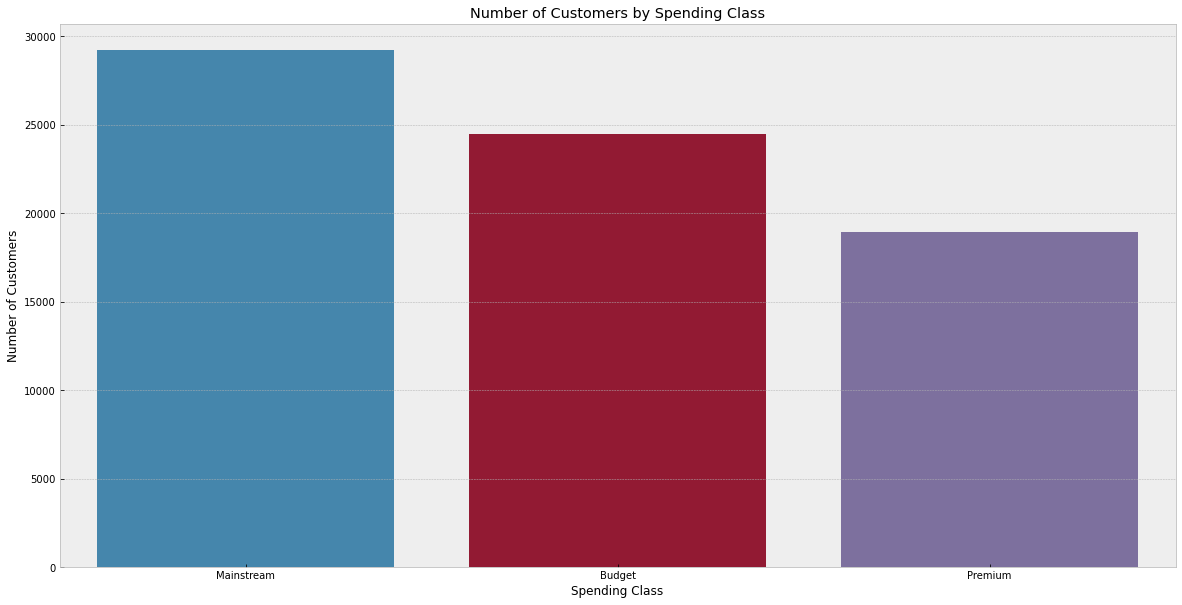

<Figure size 432x288 with 0 Axes>

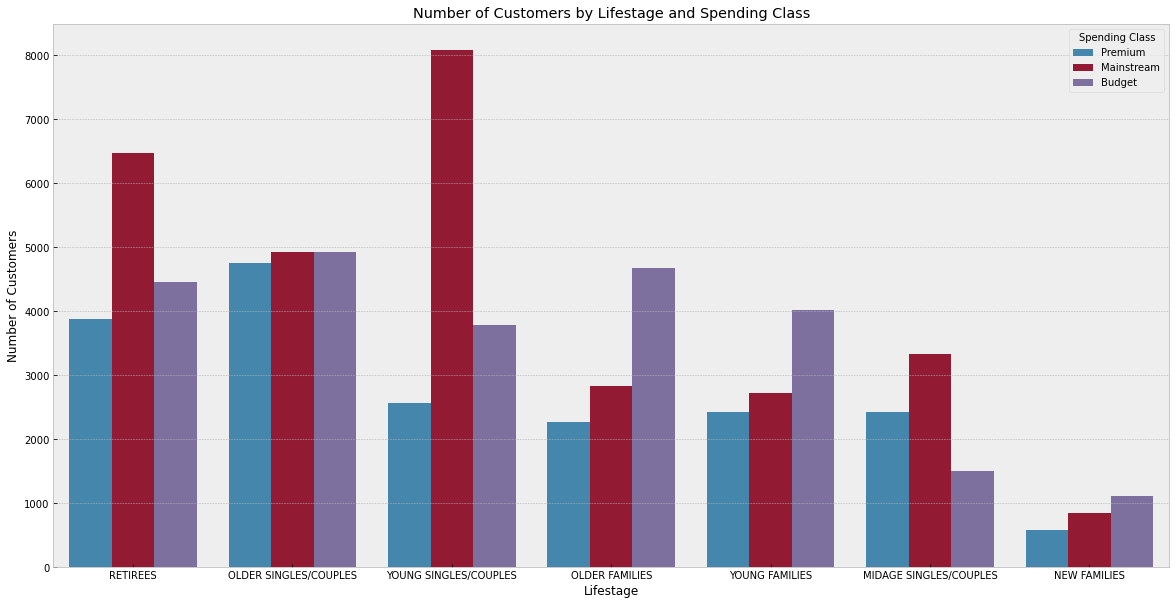

In [32]:
## Visualise Lifestage Column

# Draw plot
fig, ax = plt.subplots(figsize=(20,10))

# count Plots
sns.countplot(data=df_cust, x='LIFESTAGE', order=df_cust['LIFESTAGE'].value_counts().index)

# Formatting
ax.set_title('Number of Customers by Lifestage')
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Lifestage')

plt.show()
plt.clf()

## Visualise Spending Class column

# Draw plot
fig, ax = plt.subplots(figsize=(20,10))

# Count Plot
sns.countplot(data=df_cust, x='PREMIUM_CUSTOMER', order=df_cust['PREMIUM_CUSTOMER'].value_counts().index)

# Formatting
ax.set_title('Number of Customers by Spending Class')
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Spending Class')

plt.show()
plt.clf()

## Visualise Lifestage and Spending Class together

# Draw plot
fig, ax = plt.subplots(figsize=(20,10))

# count Plots
sns.countplot(data=df_cust, x='LIFESTAGE', hue='PREMIUM_CUSTOMER', order=df_cust['LIFESTAGE'].value_counts().index)

# Formatting
ax.set_title('Number of Customers by Lifestage and Spending Class')
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Lifestage')
ax.legend(title='Spending Class')

plt.show()

- Most loyalty customers are Retirees, Older Singles/Couples, Young Singles/couples
    - Of these majority groups, most of the premium customers fall in the Older Singles/Couples group
    
Based on the above, we can proceed with merging the two dataframes together to continue the analysis

---

#### Merge dataframes

In [33]:
# Check shape of each before
display(df_trans.shape)
display(df_cust.shape)

#Conduct the merge
df = pd.merge(df_trans, df_cust, on='LYLTY_CARD_NBR')

#Check the merge
display(df.head())
display(df.shape)
display(df.info())

##Merge successful, as same number of rows after the merge. Additionally, there are no nulls present after the merge.

(246740, 10)

(72637, 3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,packet_size,brand_name,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural Chip Company,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,160,Woolworths,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,175,CCs,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget


(246740, 12)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246740 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  category      
 2   LYLTY_CARD_NBR    246740 non-null  int64         
 3   TXN_ID            246740 non-null  category      
 4   PROD_NBR          246740 non-null  category      
 5   PROD_NAME         246740 non-null  object        
 6   PROD_QTY          246740 non-null  int64         
 7   TOT_SALES         246740 non-null  float64       
 8   packet_size       246740 non-null  object        
 9   brand_name        246740 non-null  object        
 10  LIFESTAGE         246740 non-null  object        
 11  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 32.5+ MB


None

## Data Analysis

- What is the average sale by Lifestage & Customer?
- What is the average quantity by Lifestage & Customer?
- What is the most common packet size by Lifestage & Customer?
- What is the most common Brand by Lifestage & Customer?
- Which lifestage drives highest sales?
- Which customer type drives highest sales?
- Whats the relationship between packet size and total sales?



- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How mayn chips are bought per customer by segment
- What's the average chip price by customer segment

We'll begin the analysis by first understanding how many customers we have in each segment, as this will have an impact on the other metrics we explore. For example, we'd expect a higher amount of sales in a certain category if they have twice as many customers than another category.

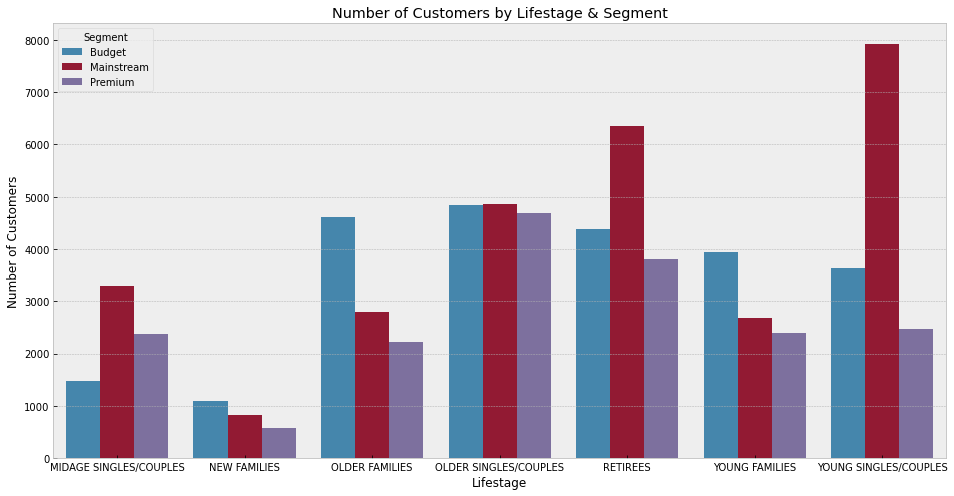

In [34]:
# How many customers are there in each segment?
num_cust = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'LYLTY_CARD_NBR': 'nunique'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=num_cust, x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER')

# Formatting
ax.set_title('Number of Customers by Lifestage & Segment')
ax.set_xlabel('Lifestage')
ax.set_ylabel('Number of Customers')
ax.legend(title='Segment')

plt.show()

Young Singles/Couples - Mainstream & Retirees - Mainstreams are the segments that purchase more chips relative to the other categories. There are 7917 and 6358 customers in each segment respectively.

---

Let's now explore the total sales made by each segment

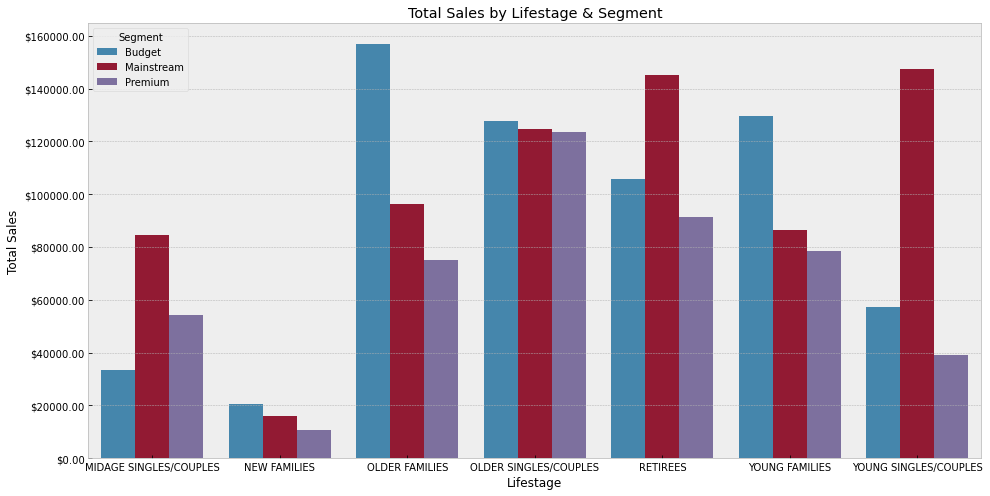

In [35]:
# What are the total sales by each segment?
tot_sales = df.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg({'TOT_SALES': 'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=tot_sales, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')

# Formatting
ax.set_title('Total Sales by Lifestage & Segment')
ax.set_xlabel('Lifestage')
ax.set_ylabel('Total Sales')
ax.legend(title='Segment')
ax.yaxis.set_major_formatter('${x:1.2f}')

plt.show()

Older Families - Budget, Young Singles/Couples - Mainstream, Retirees - Mainstream, Young Families - Budget are the primary drivers of sales. The two in the mainstream categories are expected, given the higher number of customers, though there appears to be other factors driving sales in Budget - Older Families + Young Families.

---

Let's try and better understand what is driving the sales in these two budget categories. We'll start by looking at the average number of units purchased per customer.

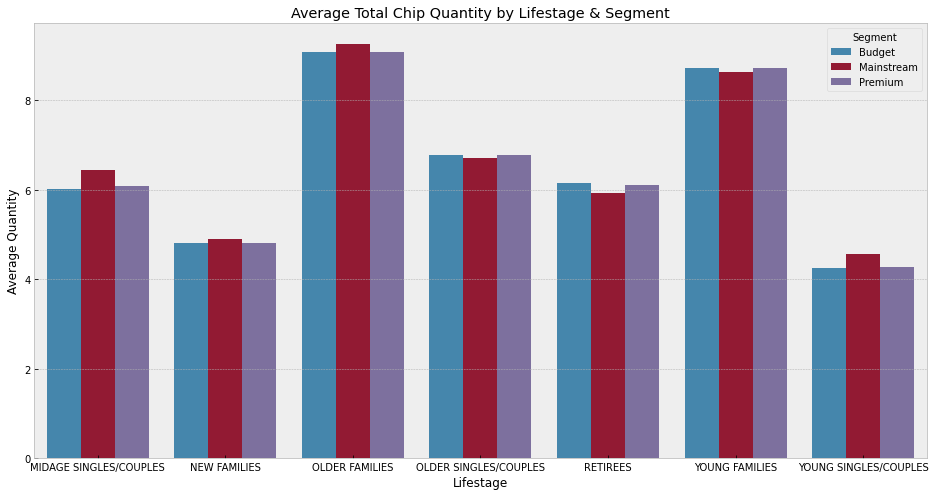

In [36]:
# How many chip packets do customers purchase on average?

cust_unit = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'LYLTY_CARD_NBR': 'nunique', 'PROD_QTY': 'sum'}).reset_index()

cust_unit['quant_per_customer'] = cust_unit.PROD_QTY/cust_unit.LYLTY_CARD_NBR

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=cust_unit, x='LIFESTAGE', y='quant_per_customer', hue='PREMIUM_CUSTOMER')

# Formatting
ax.set_title('Average Total Chip Quantity by Lifestage & Segment')
ax.set_xlabel('Lifestage')
ax.set_ylabel('Average Quantity')
ax.legend(title='Segment')

plt.show()

On average, Older Families and Young Families purchase more chip packets, relative to the other segments. This would be a part of the explanation as to why Budget Older Families & Young Families contribute strongly to total sales. 

---

Let's also explore average price per unit chips bought for each customer segment

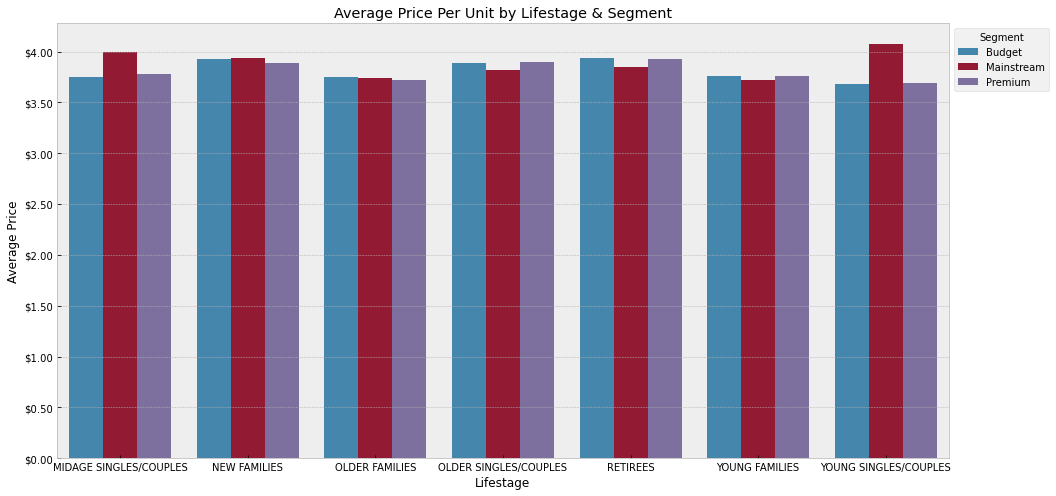

In [37]:
# How much do customers pay per unit of chip packets purchased?

cust_sale = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'PROD_QTY':'sum','TOT_SALES':'sum'}).reset_index()

cust_sale['avg_price_per_unit'] = cust_sale.TOT_SALES/cust_sale.PROD_QTY

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=cust_sale, x='LIFESTAGE', y='avg_price_per_unit', hue='PREMIUM_CUSTOMER')

# Formatting
ax.set_title('Average Price Per Unit by Lifestage & Segment')
ax.set_xlabel('Lifestage')
ax.set_ylabel('Average Price')
ax.legend(title='Segment')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter('${x:1.2f}')

plt.show()

Mainstream Midage and Young Singles/Couples are more likely to pay more for chips, relative to their Budget and Premium counterparts. This may be due to these customer segments purchasing "healthier" chip alternatives, which are the more expensive option. We can look at drilling down on these segments to see if they do in fact purchase differently to the other segments.

Note that the differences between the segments aren't very large, so we can conduct a t-test to test if the differences are statistically significant.

In [38]:
# Create Average Price Column
df.loc[:,'unit_price'] = df.TOT_SALES/df.PROD_QTY

# Dataframe for Midage Singles/Couples Mainstream + Create Average Price Column

df_mid_main = df[(df.LIFESTAGE == 'MIDAGE SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Mainstream')]

# Dataframe for Midage Singles/Couples Budget + Create Average Price Column

df_mid_budget = df[(df.LIFESTAGE == 'MIDAGE SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Budget')]

# Dataframe for Midage Singles/Couples Premium + Create Average Price Column

df_mid_prem = df[(df.LIFESTAGE == 'MIDAGE SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Premium')]

# Check Shape
display(df_mid_main.shape)
display(df_mid_budget.shape)
display(df_mid_prem.shape)

# Create Samples
mid_main_sample = df_mid_main.unit_price.sample(4000)
mid_budget_sample = df_mid_budget.unit_price.sample(4000)
mid_prem_sample = df_mid_prem.unit_price.sample(4000)

# Perform T-Test - Midage Main Vs Budget
display(stats.ttest_ind(mid_main_sample, mid_budget_sample))

# Perform T-Test - Midage Main vs Premium
display(stats.ttest_ind(mid_main_sample, mid_prem_sample))

(11095, 13)

(4691, 13)

(7612, 13)

Ttest_indResult(statistic=10.261812455683973, pvalue=1.4862597192397453e-24)

Ttest_indResult(statistic=9.295598982121595, pvalue=1.8553858263974522e-20)

In [39]:
# Dataframe for Young Singles/Couples Mainstream
df_youn_main = df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Mainstream')]

# Dataframe for Young Singles/Couples Budget + Create Average Price Column
df_youn_budget = df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Budget')]

# Dataframe for Young Singles/Couples Premium + Create Average Price Column
df_youn_prem = df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Premium')]

# Check Shape
display(df_youn_main.shape)
display(df_youn_budget.shape)
display(df_youn_prem.shape)

# Create Samples
youn_main_sample = df_youn_main.unit_price.sample(4000)
youn_budget_sample = df_youn_budget.unit_price.sample(4000)
youn_prem_sample = df_youn_prem.unit_price.sample(4000)

# Perform T-Test - Midage Main Vs Budget
display(stats.ttest_ind(youn_main_sample, youn_budget_sample))

# Perform T-Test - Midage Main vs Premium
display(stats.ttest_ind(youn_main_sample, youn_prem_sample))

(19544, 13)

(8573, 13)

(5852, 13)

Ttest_indResult(statistic=17.34336313527641, pvalue=3.5599279557280294e-66)

Ttest_indResult(statistic=17.144814931352226, pvalue=9.769149130422095e-65)

All tests produced very small p-values, meaning there does appear to be a signficant difference in unit price for Mainstream Young/Midage Singles & Couples compared to their Budget and Premium counterparts.

---

We'll now explore if Midage Singles/Couples - Mainstream purchase particular brands of chips, that explains their higher unit price.

Though first we'll work out the average unit price based on brand.

In [40]:
# Create dataframe with only unique Products + Select relevant columns
df_price_list = df.drop_duplicates(subset=['PROD_NAME']).reset_index()
df_price_list_final = df_price_list[['PROD_NAME', 'packet_size', 'brand_name', 'unit_price']]

# Groupby brand and average price
display(df_price_list_final.groupby('brand_name').agg({'unit_price':'mean'}).sort_values(by='unit_price', ascending=False))

,unit_price
brand_name,
Kettle,4.938462
Twisties,4.500000
Tostitos,4.400000
Doritos,4.293750
Tyrrells,4.200000
Cheezels,3.900000
Cobs,3.800000
Pringles,3.700000
Infuzions,3.520000


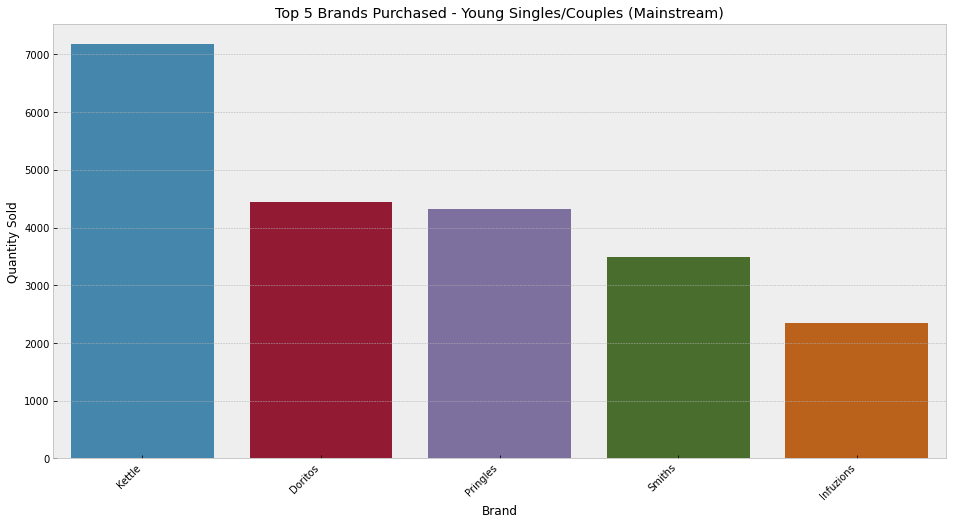

In [41]:
# Filter for Mainstream - Young Singles/Couples has been completed above.

df_youn_main_grouped = df_youn_main.groupby('brand_name').agg({'PROD_QTY':'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=df_youn_main_grouped, x='brand_name', y='PROD_QTY',
            order=df_youn_main_grouped.sort_values('PROD_QTY', ascending=False).brand_name[:5])

# Formatting
ax.set_title('Top 5 Brands Purchased - Young Singles/Couples (Mainstream)')
ax.set_xlabel('Brand')
ax.set_ylabel('Quantity Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='right')

plt.show()

We can see that the Kettle brand is the most popular brand for Young Singles/Couples - Mainstream. This brand also has the highest average unit price across it's products, which could be part of the reason this segment performs so well. This segment actually purchases a smaller number of packets, relative to other segments, though because this segment appears to choose quality over quantity, they contribute a large portion to total sales.

We'll also check which packet sizes are the most popular in this segment

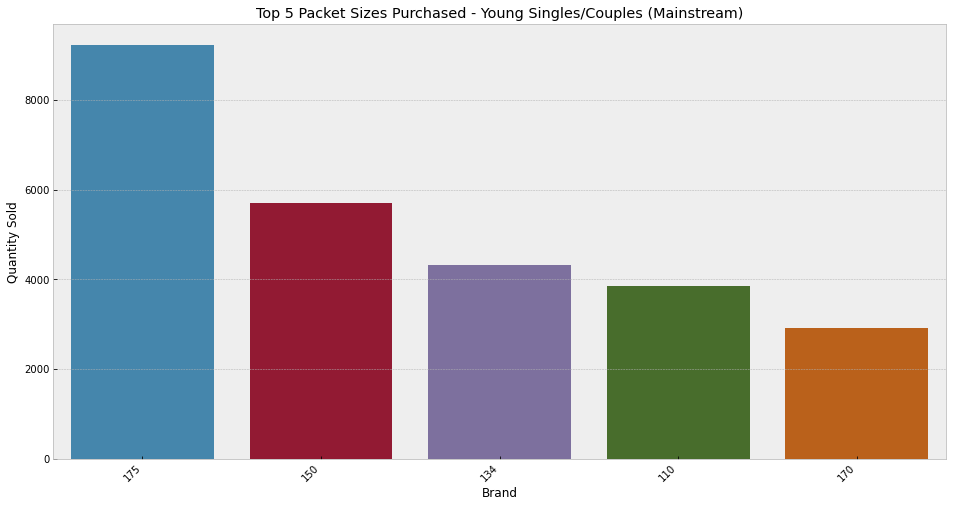

In [42]:
# Filter for Mainstream - Young Singles/Couples has been completed above.

df_youn_main_grouped = df_youn_main.groupby('packet_size').agg({'PROD_QTY':'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=df_youn_main_grouped, x='packet_size', y='PROD_QTY',
            order=df_youn_main_grouped.sort_values('PROD_QTY', ascending=False).packet_size[:5])

# Formatting
ax.set_title('Top 5 Packet Sizes Purchased - Young Singles/Couples (Mainstream)')
ax.set_xlabel('Brand')
ax.set_ylabel('Quantity Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='right')

plt.show()

Young Singles/Couples - Mainstream tend to purchase chip packets between 110g - 175g.

Let's do the same analysis as above, though this time for Midage Singles/Couples - Mainstream

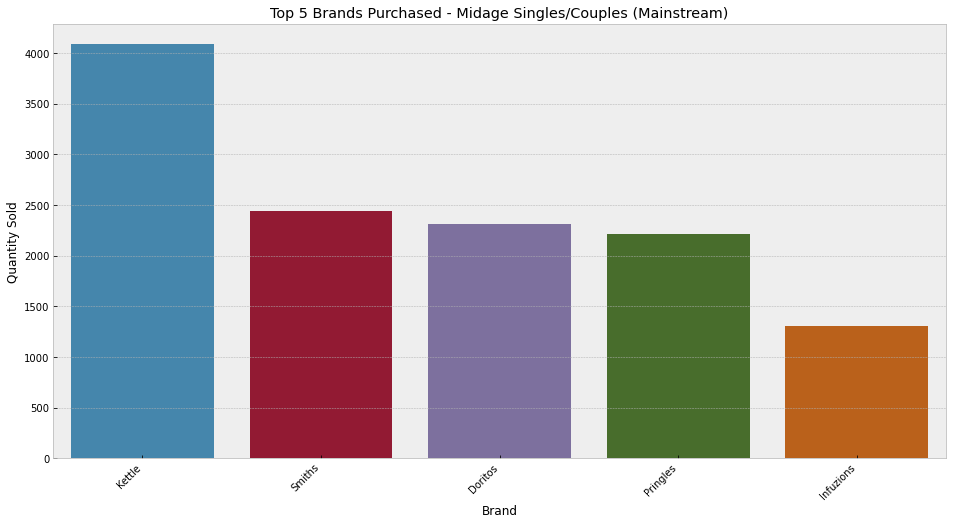

<Figure size 432x288 with 0 Axes>

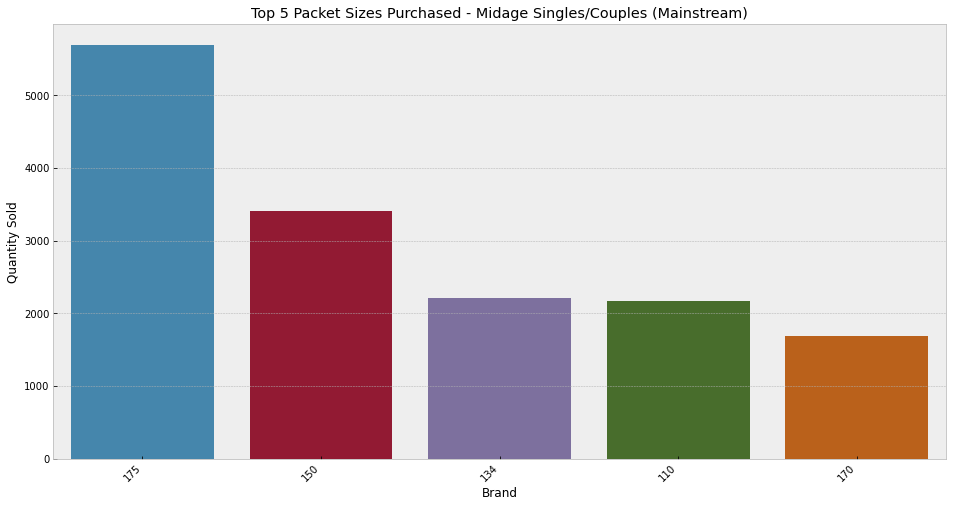

In [43]:
# Filter for Mainstream - midage Singles/Couples has been completed above.

df_mid_main_grouped = df_mid_main.groupby('brand_name').agg({'PROD_QTY':'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=df_mid_main_grouped, x='brand_name', y='PROD_QTY',
            order=df_mid_main_grouped.sort_values('PROD_QTY', ascending=False).brand_name[:5])

# Formatting
ax.set_title('Top 5 Brands Purchased - Midage Singles/Couples (Mainstream)')
ax.set_xlabel('Brand')
ax.set_ylabel('Quantity Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='right')

plt.show()
plt.clf()

# Filter for Mainstream - midage Singles/Couples has been completed above.

df_mid_main_grouped = df_mid_main.groupby('packet_size').agg({'PROD_QTY':'sum'}).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(data=df_mid_main_grouped, x='packet_size', y='PROD_QTY',
            order=df_mid_main_grouped.sort_values('PROD_QTY', ascending=False).packet_size[:5])

# Formatting
ax.set_title('Top 5 Packet Sizes Purchased - Midage Singles/Couples (Mainstream)')
ax.set_xlabel('Brand')
ax.set_ylabel('Quantity Sold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='right')

plt.show()

The midage singles/couples - mainstream segment has a very similar purchasing pattern to their young single/couples counterparts, the major difference is that young people appear to just purchase more chips overall, which would explain the difference in total sales between these two segments.

One thing to point out, is that midage singles/couples - mainstream purchase more chip packets on avergae compared to young singles/couples - mainstream. We would expect that if there was the ability to attract more people in the midage singles/couples - mainstream, that this segment would be a strong driver of sales.

However, this may be challenging, as part of the reason for the lower number of customers in this segment could be due to health reasons.

---

We'll finish off by doing affinity analysis.

In [44]:
# Select segment to analyse + all other segments

segment1 = df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Mainstream')]
other = df[~((df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Mainstream'))]

# Groupby Brand & Calculate Quantity Sum
segment1_grouped = segment1.groupby('brand_name').agg({'PROD_QTY': 'sum'})
other_grouped = other.groupby('brand_name').agg({'PROD_QTY': 'sum'})

# Create Proportion Column
segment1_grouped['proportion'] = segment1_grouped.PROD_QTY/segment1_grouped.PROD_QTY.sum()
other_grouped['proportion'] = other_grouped.PROD_QTY/other_grouped.PROD_QTY.sum()

# display(segment1_grouped)
# display(other_grouped)

# Merge frames
affin_analy = pd.merge(segment1_grouped, other_grouped, left_index=True, right_index=True, 
                       suffixes=('_target', '_other'))

affin_analy = affin_analy[['proportion_target', 'proportion_other']]
affin_analy.loc[:,'affinity'] = affin_analy.proportion_target/affin_analy.proportion_other
affin_analy = affin_analy.sort_values(by='affinity', ascending=False)

display(affin_analy)

,proportion_target,proportion_other,affinity
brand_name,,,
Tyrrells,0.031553,0.025692,1.228095
Twisties,0.046184,0.037877,1.219319
Doritos,0.122761,0.101075,1.214553
Kettle,0.197985,0.165553,1.195897
Tostitos,0.045411,0.037978,1.195713
Pringles,0.119420,0.100635,1.186670
Cobs,0.044638,0.039049,1.143124
Infuzions,0.064679,0.057065,1.133435
Thins,0.060373,0.056986,1.059423


We can see from the above the brand affinity Young Singles/Couples - Mainstream segment has. You can note that they're most likely to purchase the brands that have the higher unit prices, which further explains their contribution to driving total sales.

In [45]:
# Select segment to analyse + all other segments

segment1 = df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Mainstream')]
other = df[~((df.LIFESTAGE == 'YOUNG SINGLES/COUPLES') & (df.PREMIUM_CUSTOMER == 'Mainstream'))]

# Groupby Brand & Calculate Quantity Sum
segment1_grouped = segment1.groupby('packet_size').agg({'PROD_QTY': 'sum'})
other_grouped = other.groupby('packet_size').agg({'PROD_QTY': 'sum'})

# Create Proportion Column
segment1_grouped['proportion'] = segment1_grouped.PROD_QTY/segment1_grouped.PROD_QTY.sum()
other_grouped['proportion'] = other_grouped.PROD_QTY/other_grouped.PROD_QTY.sum()

# display(segment1_grouped)
# display(other_grouped)

# Merge frames
affin_analy = pd.merge(segment1_grouped, other_grouped, left_index=True, right_index=True, 
                       suffixes=('_target', '_other'))

affin_analy = affin_analy[['proportion_target', 'proportion_other']]
affin_analy.loc[:,'affinity'] = affin_analy.proportion_target/affin_analy.proportion_other
affin_analy = affin_analy.sort_values(by='affinity', ascending=False)

display(affin_analy)

,proportion_target,proportion_other,affinity
packet_size,,,
270,0.031829,0.025096,1.268287
380,0.032160,0.025584,1.257030
330,0.061284,0.050162,1.221717
134,0.119420,0.100635,1.186670
110,0.106280,0.089791,1.183637
210,0.029124,0.025121,1.159318
135,0.014769,0.013075,1.129511
250,0.014355,0.012781,1.123166
170,0.080773,0.080986,0.997370


This segment is also more likely to purchase 270g, 380g, and 330g packets compared to the rest of segments. These packets have a higher unit price, further explaining why this segment contributes a large portion to total sales.

---

# Conclusion



The above analysed the chip purchasing activity for 72,6737 customers, across a 12 month period. These customers were segmented across 7 different lifestages, and within each lifestage 3 spending segments. Mainstream Retirees and Young Singles/Couples are the segment most likely to purchase chips. 

Total sales are driven mainly by Budget - Older Families/Young Families & Mainstream - Young Singles/Couples & Retirees. The sales in the Mainstream category for these customers, can be attributed to there being a larger number of customers in these segments. Additionally, Mainstream Young Singles/Customers appear to have a greater affinity to the more expensive chip packets.

Mainstream - Young Singles/Customers are more likely to purchase larger packet sizes, this could be from a greater tendency to host gatherings/parties. A recommendation could be to display these larger packet sizes, together with other party/gathering products.

Further analysis could also be done in better understanding the stores demographics, and have targeted displays for brands that the particular segment is more likely to purchase. For example, stores that have a large proportion of Mainstream - Young Singles/Customers, to ensure brands like Tyrrells & Twisties are displayed strategically to promote further purchasing.